# Artificial Intelligence Project - Bots vs Users

In this project, I clean and analyse the 'Users vs bots classification' dataset from Kaggle and then build a neural network model to classify bots from users. This dataset contains profile data collected from public profiles on VK.com (VKontakte), Russia's largest social network. 

Additional Informations:
* Data scource: https://www.kaggle.com/datasets/juice0lover/users-vs-bots-classification/data
* In the categorical columns, 1 represents True and 0 represents False.
* In the Target column, 1 represents Bot and 0 represents Human.

In [201]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# setting display options
pd.options.display.expand_frame_repr = False
pd.options.display.max_columns = 30
pd.options.display.max_rows = 100

### Loading Dataset

In [202]:
raw_df = pd.read_csv(r'Data_BotsVsUsers.csv')
raw_df.info()
raw_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5874 entries, 0 to 5873
Data columns (total 60 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   has_domain                  5874 non-null   object 
 1   has_birth_date              5874 non-null   object 
 2   has_photo                   5874 non-null   object 
 3   can_post_on_wall            5874 non-null   object 
 4   can_send_message            5874 non-null   object 
 5   has_website                 5874 non-null   object 
 6   gender                      5874 non-null   object 
 7   has_short_name              5874 non-null   object 
 8   has_first_name              5874 non-null   object 
 9   has_last_name               5874 non-null   object 
 10  access_to_closed_profile    5874 non-null   object 
 11  is_profile_closed           5874 non-null   object 
 12  target                      5874 non-null   int64  
 13  has_nickname                5874 

,has_domain,has_birth_date,has_photo,can_post_on_wall,can_send_message,has_website,gender,has_short_name,has_first_name,has_last_name,access_to_closed_profile,is_profile_closed,target,has_nickname,has_maiden_name,...,avg_keywords,avg_text_length,attachments_ratio,avg_comments,reposts_ratio,ads_ratio,avg_views,posting_frequency_days,phone_numbers_ratio,avg_text_uniqueness,city,has_occupation,occupation_type_university,occupation_type_work,has_personal_data
0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1,Unknown,Unknown,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown,Unknown,Unknown
1,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1,Unknown,Unknown,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown,Unknown,Unknown
2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1,Unknown,Unknown,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown,Unknown,Unknown
3,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1,Unknown,Unknown,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown,Unknown,Unknown
4,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1,Unknown,Unknown,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,Unknown,Unknown,Unknown,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5869,1.0,1.0,1.0,0.0,0.0,Unknown,2.0,1.0,1.0,1.0,0.0,1.0,0,0.0,Unknown,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Saint Petersburg,1.0,0.0,1.0,Unknown
5870,1.0,Unknown,1.0,0.0,0.0,Unknown,1.0,1.0,1.0,1.0,0.0,1.0,0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Saint Petersburg,1.0,1.0,0.0,Unknown
5871,1.0,1.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,1.0,1.0,0.0,0,Unknown,Unknown,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Saint Petersburg,1.0,1.0,0.0,Unknown
5872,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Moscow,1.0,0.0,1.0,Unknown


### Data Cleaning

Renaming Columns

In [203]:
for column_name in raw_df:
    new_column_name = column_name.replace(' ','_')
    raw_df.rename(columns={column_name:new_column_name.capitalize()}, inplace=True)

Correcting Datatypes

In [204]:
raw_df['Subscribers_count'] = pd.to_numeric(raw_df['Subscribers_count'], errors='coerce')

In [205]:
# Separating numerical and categorical columns
num_columns = raw_df.select_dtypes(include=['float64']).columns.tolist()
cat_columns = raw_df.select_dtypes(include=['object']).columns.tolist()

Correcting Column Values

In [206]:
# Converting Strings to UPPER CASE
for column in cat_columns:
    raw_df[column] = raw_df[column].str.upper()

In [207]:
# Rounding Floating points
for column in num_columns:
    raw_df[column] = raw_df[column].round(2)

In [208]:
# Converting City values to GIVEN (instead of city names) or UNKNOWN
# To control the number of features after Encoding
raw_df['City'] = raw_df['City'].where(raw_df['City'] == 'UNKNOWN', other='GIVEN')

Fixing Null Values

In [209]:
# Checking for Null values
print(raw_df.isna().sum())

Has_domain                       0
Has_birth_date                   0
Has_photo                        0
Can_post_on_wall                 0
Can_send_message                 0
Has_website                      0
Gender                           0
Has_short_name                   0
Has_first_name                   0
Has_last_name                    0
Access_to_closed_profile         0
Is_profile_closed                0
Target                           0
Has_nickname                     0
Has_maiden_name                  0
Has_mobile                       0
All_posts_visible                0
Audio_available                  0
Has_interests                    0
Has_books                        0
Has_tv                           0
Has_quotes                       0
Has_about                        0
Has_games                        0
Has_movies                       0
Has_activities                   0
Has_music                        0
Can_add_as_friend                0
Can_invite_to_group 

In [210]:
# Filling Null values in numerical columns with mean
raw_df[num_columns] = raw_df[num_columns].fillna(raw_df[num_columns].mean())

In [211]:
# Checking for Null values again
print(raw_df.isna().sum())

Has_domain                    0
Has_birth_date                0
Has_photo                     0
Can_post_on_wall              0
Can_send_message              0
Has_website                   0
Gender                        0
Has_short_name                0
Has_first_name                0
Has_last_name                 0
Access_to_closed_profile      0
Is_profile_closed             0
Target                        0
Has_nickname                  0
Has_maiden_name               0
Has_mobile                    0
All_posts_visible             0
Audio_available               0
Has_interests                 0
Has_books                     0
Has_tv                        0
Has_quotes                    0
Has_about                     0
Has_games                     0
Has_movies                    0
Has_activities                0
Has_music                     0
Can_add_as_friend             0
Can_invite_to_group           0
Subscribers_count             0
Is_blacklisted                0
Has_care

Shuffling the rows

In [212]:
raw_df = shuffle(raw_df, random_state=42).reset_index(drop=True)

### Statistical Analysis

Describe

In [213]:
raw_df.describe()

,Target,Subscribers_count,Posts_count,Avg_likes,Links_ratio,Hashtags_ratio,Avg_keywords,Avg_text_length,Attachments_ratio,Avg_comments,Reposts_ratio,Ads_ratio,Avg_views,Posting_frequency_days,Phone_numbers_ratio,Avg_text_uniqueness
count,5874.000000,5874.000000,5874.000000,5874.000000,5874.000000,5874.000000,5874.000000,5874.000000,5874.000000,5874.000000,5874.000000,5874.000000,5874.000000,5874.000000,5874.000000,5874.000000
mean,0.500000,1730.940769,18.629044,19.552487,0.156463,0.143918,7.730661,544.752035,0.895945,0.610812,0.433638,0.002667,623.834788,66.330065,0.000568,0.668009
std,0.500043,2395.533429,2.058839,20.410794,0.098627,0.091016,5.487024,363.278681,0.082745,1.197607,0.193542,0.016120,786.969785,75.392104,0.004644,0.111804
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,794.250000,18.629044,19.552487,0.156463,0.143918,7.730661,544.752035,0.895945,0.610812,0.433638,0.002667,623.834788,66.330065,0.000568,0.668009
50%,0.500000,1730.940769,18.629044,19.552487,0.156463,0.143918,7.730661,544.752035,0.895945,0.610812,0.433638,0.002667,623.834788,66.330065,0.000568,0.668009
75%,1.000000,1730.940769,18.629044,19.552487,0.156463,0.143918,7.730661,544.752035,0.895945,0.610812,0.433638,0.002667,623.834788,66.330065,0.000568,0.668009
max,1.000000,103729.000000,20.000000,894.900000,1.000000,1.000000,61.600000,5841.250000,1.000000,64.050000,1.000000,0.950000,41415.700000,2866.590000,0.300000,1.000000


Correlation

                          Target  Subscribers_count  Posts_count  Avg_likes  Links_ratio  Hashtags_ratio  Avg_keywords  Avg_text_length  Attachments_ratio  Avg_comments  Reposts_ratio  Ads_ratio  Avg_views  Posting_frequency_days  Phone_numbers_ratio  Avg_text_uniqueness
Target                  1.000000          -0.109384     0.017408  -0.099149     0.137202        0.069412      0.244162         0.228617           0.034398     -0.052538       0.231727   0.006094  -0.082098               -0.073396            -0.005494            -0.066598
Subscribers_count      -0.109384           1.000000     0.089987   0.480714    -0.037908       -0.001598     -0.082861        -0.081232           0.106473      0.372715      -0.167865  -0.008209   0.457649               -0.046668             0.003224             0.106913
Posts_count             0.017408           0.089987     1.000000   0.008095     0.119395        0.185558      0.159347         0.160023           0.121975      0.013623       0.178730 

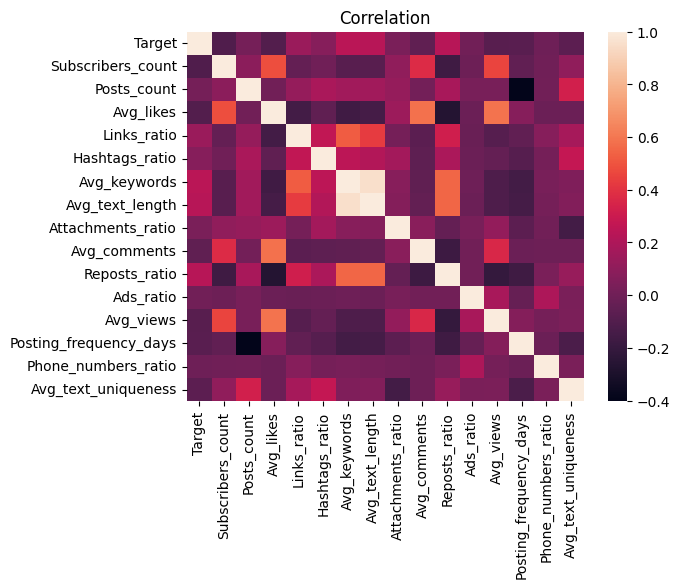

In [214]:
print(raw_df.corr(numeric_only=True))
sns.heatmap(raw_df.corr(numeric_only=True))
plt.title('Correlation')
plt.show()

Covariance

In [215]:
raw_df.cov(numeric_only=True)

,Target,Subscribers_count,Posts_count,Avg_likes,Links_ratio,Hashtags_ratio,Avg_keywords,Avg_text_length,Attachments_ratio,Avg_comments,Reposts_ratio,Ads_ratio,Avg_views,Posting_frequency_days,Phone_numbers_ratio,Avg_text_uniqueness
Target,0.250043,-1.310283e+02,0.017922,-1.011942,0.006766,0.003159,0.669918,41.529304,0.001423,-0.031463,0.022426,0.000049,-32.306989,-2.766981,-0.000013,-0.003723
Subscribers_count,-131.028262,5.738580e+06,443.817978,23504.371655,-8.956355,-0.348439,-1089.149059,-70691.953024,21.104868,1069.284865,-77.828191,-0.316992,862766.160809,-8428.507564,0.035862,28.634546
Posts_count,0.017922,4.438180e+02,4.238819,0.340191,0.024244,0.034771,1.800131,119.686266,0.020779,0.033589,0.071219,0.000846,41.196166,-62.391843,0.000041,0.074903
Avg_likes,-1.011942,2.350437e+04,0.340191,416.600508,-0.312107,-0.100938,-18.095978,-1098.359704,0.244383,14.267088,-1.054526,-0.006024,9415.542385,112.372469,-0.001454,-0.040134
Links_ratio,0.006766,-8.956355e+00,0.024244,-0.312107,0.009727,0.002348,0.282139,15.322298,0.000120,-0.008207,0.006074,-0.000035,-6.950019,-0.375629,0.000034,0.001959
Hashtags_ratio,0.003159,-3.484387e-01,0.034771,-0.100938,0.002348,0.008284,0.124086,7.165832,0.001230,-0.006442,0.003430,-0.000021,-2.693843,-0.594030,0.000006,0.002816
Avg_keywords,0.669918,-1.089149e+03,1.800131,-18.095978,0.282139,0.124086,30.107431,1900.757205,0.034660,-0.362225,0.583257,-0.000486,-499.499682,-63.319226,0.000665,0.031229
Avg_text_length,41.529304,-7.069195e+04,119.686266,-1098.359704,15.322298,7.165832,1900.757205,131971.399738,2.019120,-19.539614,38.535682,-0.086293,-32382.562953,-4099.496033,0.029619,2.574419
Attachments_ratio,0.001423,2.110487e+01,0.020779,0.244383,0.000120,0.001230,0.034660,2.019120,0.006847,0.008274,-0.000619,0.000040,7.363908,-0.412110,0.000003,-0.001412
Avg_comments,-0.031463,1.069285e+03,0.033589,14.267088,-0.008207,-0.006442,-0.362225,-19.539614,0.008274,1.434262,-0.040154,0.000108,333.982690,-1.222253,-0.000060,-0.001249


Pair Plot

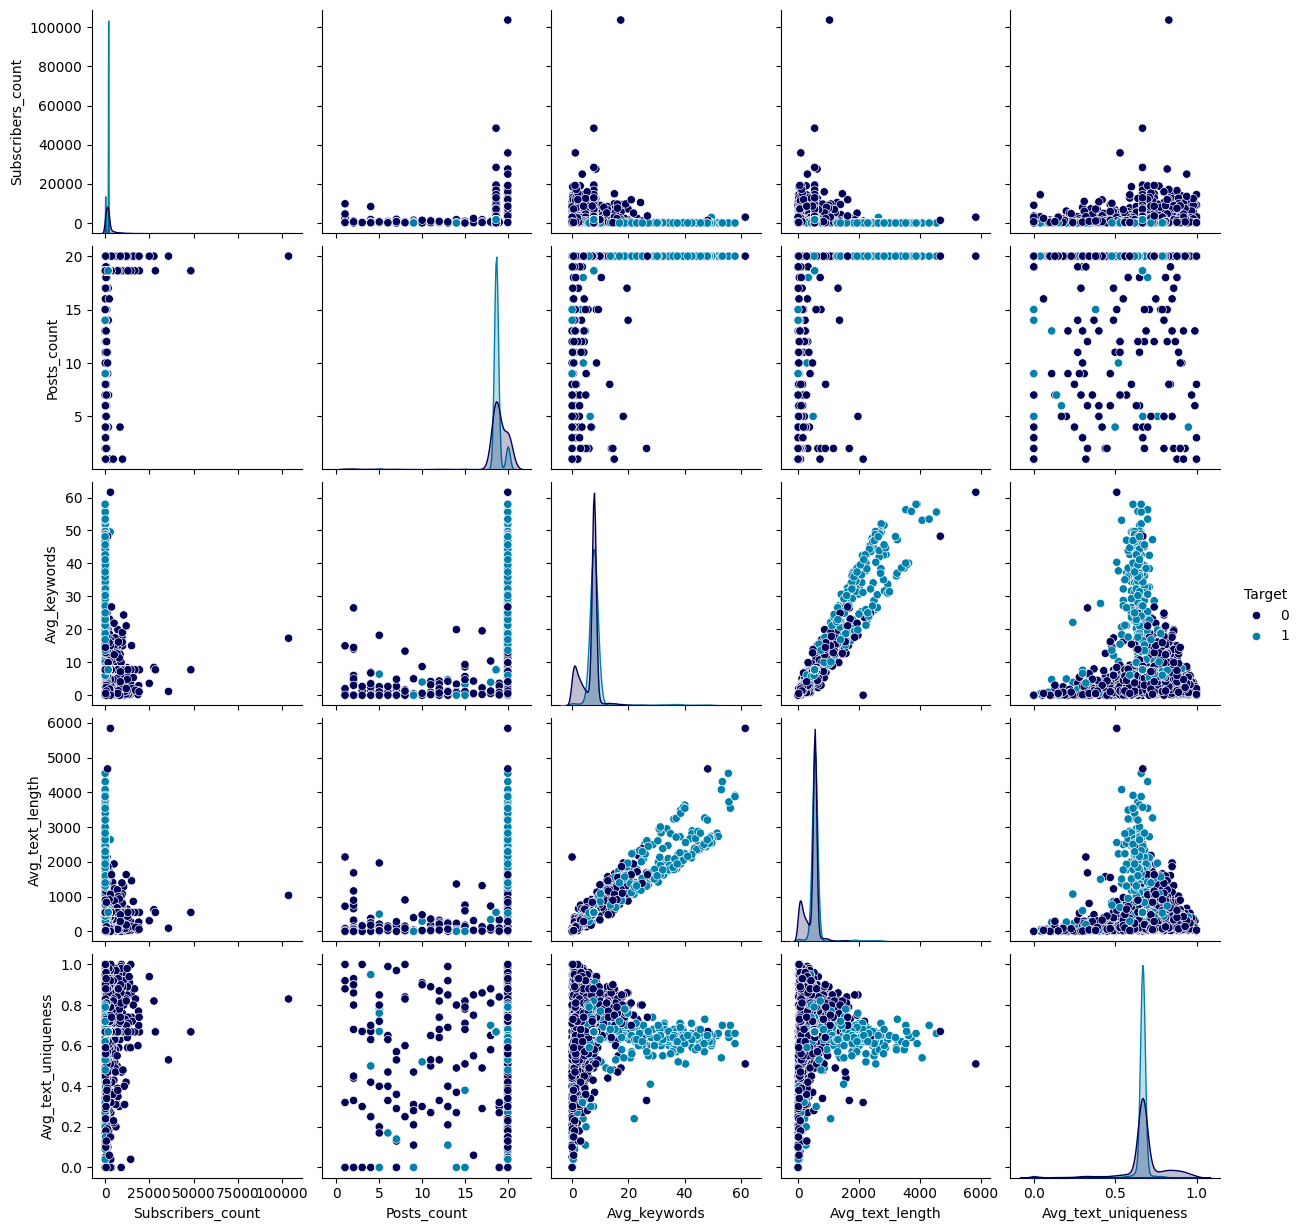

In [216]:
sns.pairplot(raw_df, vars=['Subscribers_count', 'Posts_count', 'Avg_keywords', 'Avg_text_length', 
             'Avg_text_uniqueness'], hue ='Target', palette='ocean')
plt.show()

### Cleaned Data

In [217]:
raw_df.info()
raw_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5874 entries, 0 to 5873
Data columns (total 60 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Has_domain                  5874 non-null   object 
 1   Has_birth_date              5874 non-null   object 
 2   Has_photo                   5874 non-null   object 
 3   Can_post_on_wall            5874 non-null   object 
 4   Can_send_message            5874 non-null   object 
 5   Has_website                 5874 non-null   object 
 6   Gender                      5874 non-null   object 
 7   Has_short_name              5874 non-null   object 
 8   Has_first_name              5874 non-null   object 
 9   Has_last_name               5874 non-null   object 
 10  Access_to_closed_profile    5874 non-null   object 
 11  Is_profile_closed           5874 non-null   object 
 12  Target                      5874 non-null   int64  
 13  Has_nickname                5874 

,Has_domain,Has_birth_date,Has_photo,Can_post_on_wall,Can_send_message,Has_website,Gender,Has_short_name,Has_first_name,Has_last_name,Access_to_closed_profile,Is_profile_closed,Target,Has_nickname,Has_maiden_name,...,Avg_keywords,Avg_text_length,Attachments_ratio,Avg_comments,Reposts_ratio,Ads_ratio,Avg_views,Posting_frequency_days,Phone_numbers_ratio,Avg_text_uniqueness,City,Has_occupation,Occupation_type_university,Occupation_type_work,Has_personal_data
0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0,1.0,0.0,...,8.400000,517.950000,1.000000,0.000000,0.950000,0.000000,277.050000,27.240000,0.000000,0.810000,GIVEN,1.0,1.0,0.0,UNKNOWN
1,1.0,UNKNOWN,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0,0.0,0.0,...,0.670000,27.330000,0.330000,0.000000,0.000000,0.000000,227.670000,0.000000,0.000000,0.670000,GIVEN,UNKNOWN,UNKNOWN,UNKNOWN,1.0
2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1,UNKNOWN,UNKNOWN,...,7.730661,544.752035,0.895945,0.610812,0.433638,0.002667,623.834788,66.330065,0.000568,0.668009,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN
3,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,0,UNKNOWN,UNKNOWN,...,6.800000,726.400000,1.000000,0.850000,0.400000,0.000000,163.150000,2.420000,0.000000,0.770000,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN
4,1.0,1.0,1.0,0.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,0,0.0,UNKNOWN,...,0.850000,34.800000,1.000000,0.000000,0.050000,0.000000,251.100000,22.480000,0.000000,0.100000,GIVEN,1.0,0.0,1.0,UNKNOWN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5869,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0,0.0,0.0,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1164.000000,1772.280000,0.000000,0.000000,UNKNOWN,1.0,0.0,1.0,UNKNOWN
5870,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0,0.0,0.0,...,7.730661,544.752035,0.895945,0.610812,0.433638,0.002667,623.834788,66.330065,0.000568,0.668009,GIVEN,1.0,1.0,0.0,UNKNOWN
5871,1.0,1.0,1.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,0,0.0,UNKNOWN,...,0.550000,22.500000,0.750000,0.150000,0.050000,0.000000,39.100000,111.910000,0.000000,0.590000,GIVEN,1.0,1.0,0.0,1.0
5872,1.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,0,0.0,UNKNOWN,...,7.730661,544.752035,0.895945,0.610812,0.433638,0.002667,623.834788,66.330065,0.000568,0.668009,GIVEN,1.0,1.0,0.0,UNKNOWN


### Data Analysis

##### Q1. What is the distribution of Bots and Users?

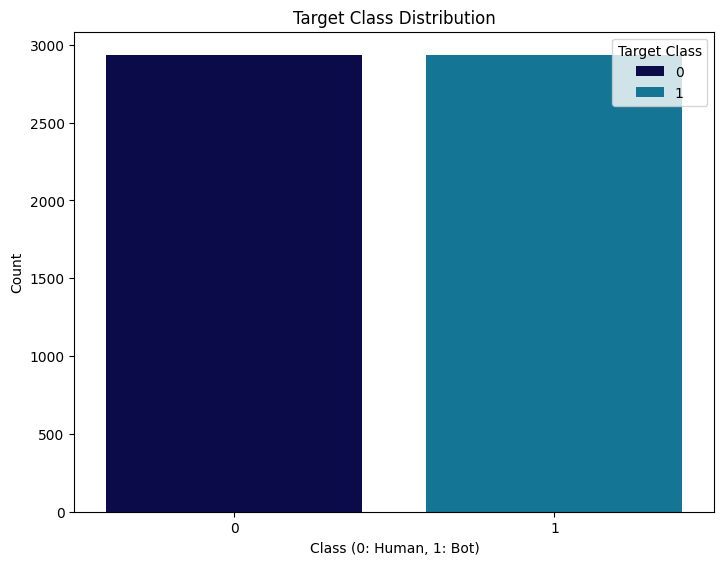

In [218]:
ax = plt.axes((0,0,1,1))
sns.countplot(x='Target', data=raw_df, hue='Target', palette='ocean', ax=ax)
ax.set_title('Target Class Distribution')
ax.set_xlabel('Class (0: Human, 1: Bot)')
ax.set_ylabel('Count')
ax.legend(title='Target Class')
plt.show()

Key points to observe from the plot:
1. The number of Bots and Humans are the same.

##### Q2. How does having a photo and Post Count help in classifying the accounts?

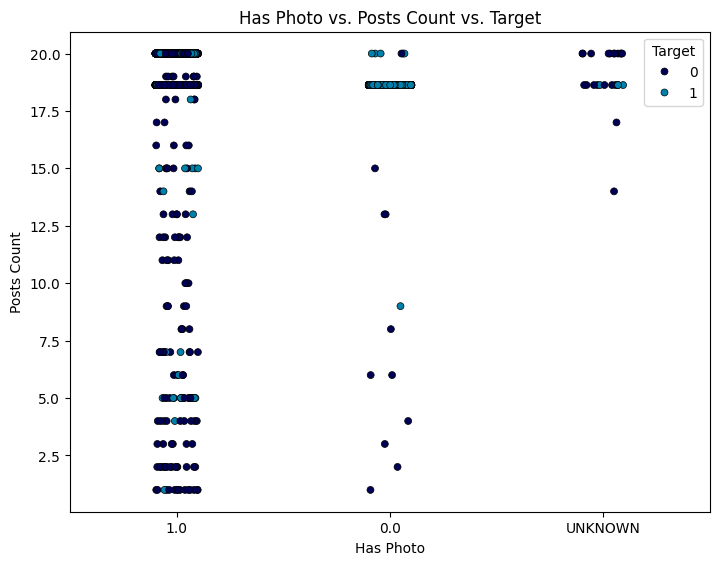

In [219]:
df = raw_df[['Target', 'Has_photo', 'Posts_count']]

ax = plt.axes((0,0,1,1))
ax = sns.stripplot(data=df, x='Has_photo', y='Posts_count', hue='Target', 
                   palette='ocean', s=5, edgecolor='k', linewidth=0.5, ax=ax)
ax.set_xlabel('Has Photo')
ax.set_ylabel('Posts Count')
ax.set_title('Has Photo vs. Posts Count vs. Target')
ax.legend(loc='best', title='Target')
plt.show()

Key points to observe from the plot:
1. Most Bots do not have a Photo whereas most Humans do.

##### Q3. How does having a mobile and Avg Keywords help in classifying the accounts?

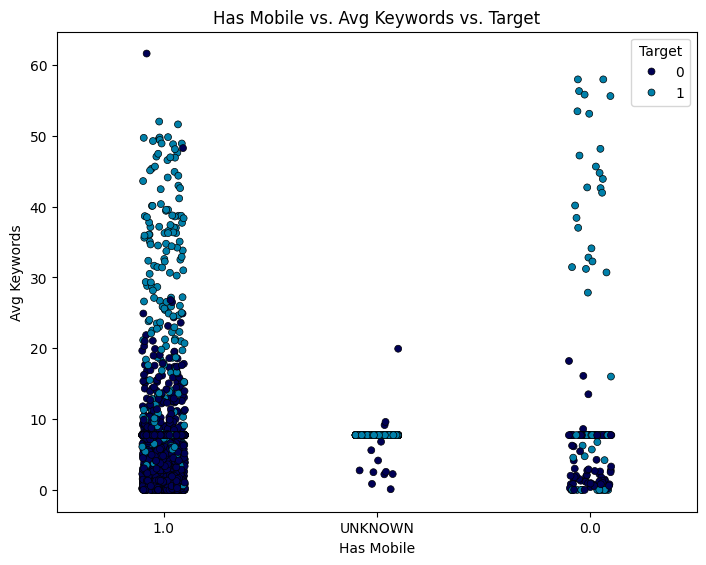

In [220]:
df = raw_df[['Target', 'Has_mobile', 'Avg_keywords']]

ax = plt.axes((0,0,1,1))
ax = sns.stripplot(data=df, x='Has_mobile', y='Avg_keywords', hue='Target', 
                   palette='ocean', s=5, edgecolor='k', linewidth=0.5, ax=ax)
ax.set_xlabel('Has Mobile')
ax.set_ylabel('Avg Keywords')
ax.set_title('Has Mobile vs. Avg Keywords vs. Target')
ax.legend(loc='best', title='Target')
plt.show()

Key points to observe from the plot:
1. Bots have higher Avg Keywords than Humans.

##### Q4. How does having an interest and Avg Text Length help in classifying the accounts?

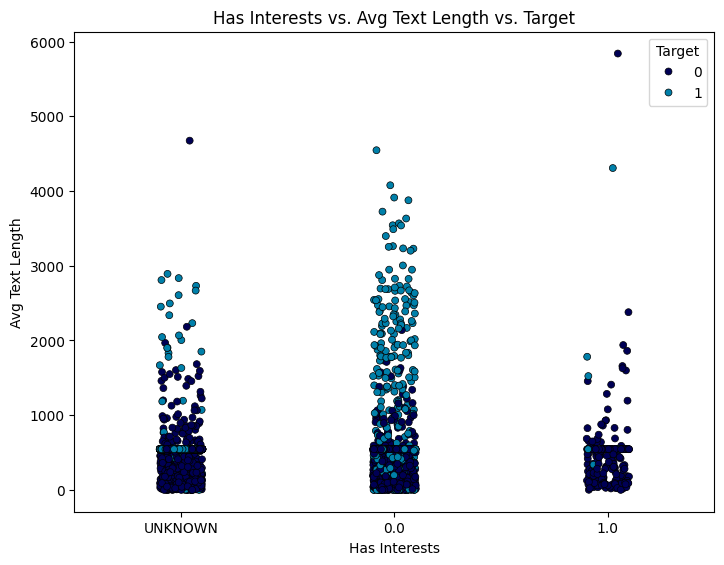

In [221]:
df = raw_df[['Target', 'Has_interests', 'Avg_text_length']]

ax = plt.axes((0,0,1,1))
ax = sns.stripplot(data=df, x='Has_interests', y='Avg_text_length', hue='Target', 
                   palette='ocean', s=5, edgecolor='k', linewidth=0.5, ax=ax)
ax.set_xlabel('Has Interests')
ax.set_ylabel('Avg Text Length')
ax.set_title('Has Interests vs. Avg Text Length vs. Target')
ax.legend(loc='best', title='Target')
plt.show()

Key points to observe from the plot:
1. Accounts that have an interest are mostly Humans.
2. Bots have higher Avg Text Length than Humans.

##### Q5. How does Being Verified and Avg Text Uniqueness help in classifying the accounts?

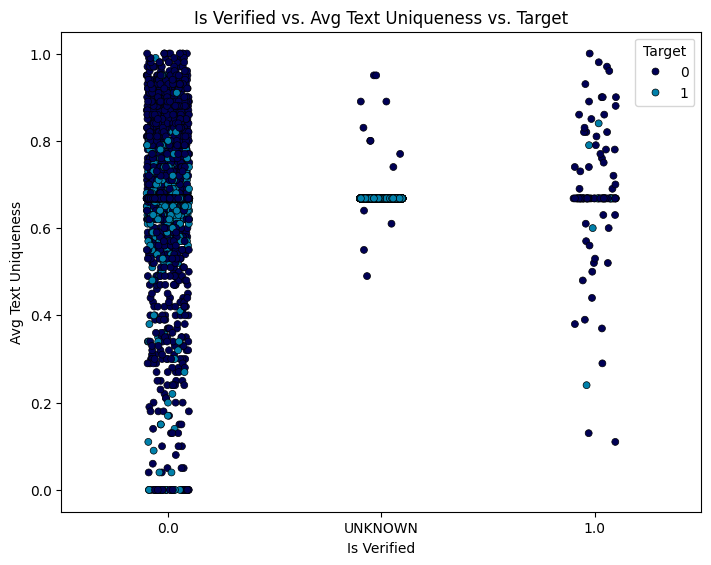

In [222]:
df = raw_df[['Target', 'Is_verified', 'Avg_text_uniqueness']]

ax = plt.axes((0,0,1,1))
ax = sns.stripplot(data=df, x='Is_verified', y='Avg_text_uniqueness', hue='Target', 
                   palette='ocean', s=5, edgecolor='k', linewidth=0.5, ax=ax)
ax.set_xlabel('Is Verified')
ax.set_ylabel('Avg Text Uniqueness')
ax.set_title('Is Verified vs. Avg Text Uniqueness vs. Target')
ax.legend(loc='best', title='Target')
plt.show()

Key points to observe from the plot:
1. Verified accounts are mostly Humans.

##### Q5. How does Avg Keywords and Avg Text Length help in classifying the accounts?

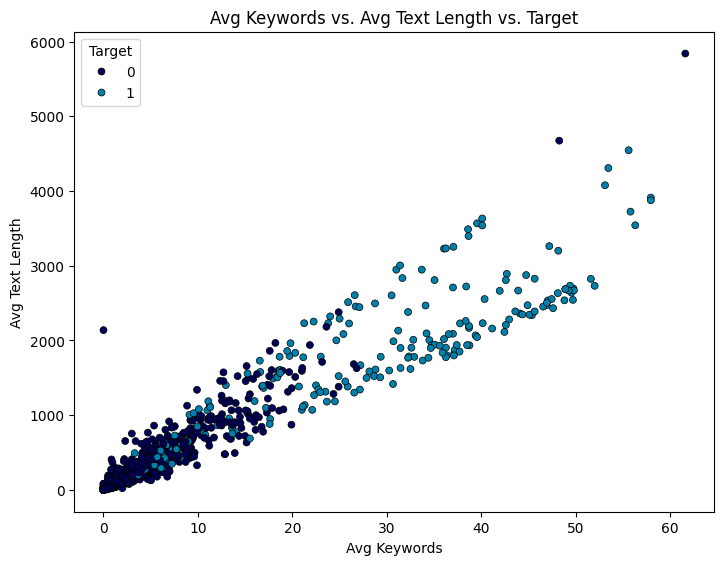

In [223]:
df = raw_df[['Target', 'Avg_keywords', 'Avg_text_length']]

ax = plt.axes((0,0,1,1))
ax = sns.scatterplot(data=df, x='Avg_keywords', y='Avg_text_length', hue='Target', 
                     palette='ocean', s=25, edgecolor='k', linewidth=0.5, ax=ax)
ax.set_xlabel('Avg Keywords')
ax.set_ylabel('Avg Text Length')
ax.set_title('Avg Keywords vs. Avg Text Length vs. Target')
ax.legend(loc='best', title='Target')
plt.show()

Key points to observe from the plot:
1. Avg Keywords is proportional to Avg Text Length.
2. Accounts with high Avg Keywords and Avg Text Length are mostly Bots.

### Building Models

In [224]:
# Data
raw_df

,Has_domain,Has_birth_date,Has_photo,Can_post_on_wall,Can_send_message,Has_website,Gender,Has_short_name,Has_first_name,Has_last_name,Access_to_closed_profile,Is_profile_closed,Target,Has_nickname,Has_maiden_name,...,Avg_keywords,Avg_text_length,Attachments_ratio,Avg_comments,Reposts_ratio,Ads_ratio,Avg_views,Posting_frequency_days,Phone_numbers_ratio,Avg_text_uniqueness,City,Has_occupation,Occupation_type_university,Occupation_type_work,Has_personal_data
0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0,1.0,0.0,...,8.400000,517.950000,1.000000,0.000000,0.950000,0.000000,277.050000,27.240000,0.000000,0.810000,GIVEN,1.0,1.0,0.0,UNKNOWN
1,1.0,UNKNOWN,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0,0.0,0.0,...,0.670000,27.330000,0.330000,0.000000,0.000000,0.000000,227.670000,0.000000,0.000000,0.670000,GIVEN,UNKNOWN,UNKNOWN,UNKNOWN,1.0
2,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1,UNKNOWN,UNKNOWN,...,7.730661,544.752035,0.895945,0.610812,0.433638,0.002667,623.834788,66.330065,0.000568,0.668009,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN
3,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,0,UNKNOWN,UNKNOWN,...,6.800000,726.400000,1.000000,0.850000,0.400000,0.000000,163.150000,2.420000,0.000000,0.770000,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN
4,1.0,1.0,1.0,0.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,0,0.0,UNKNOWN,...,0.850000,34.800000,1.000000,0.000000,0.050000,0.000000,251.100000,22.480000,0.000000,0.100000,GIVEN,1.0,0.0,1.0,UNKNOWN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5869,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0,0.0,0.0,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1164.000000,1772.280000,0.000000,0.000000,UNKNOWN,1.0,0.0,1.0,UNKNOWN
5870,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0,0.0,0.0,...,7.730661,544.752035,0.895945,0.610812,0.433638,0.002667,623.834788,66.330065,0.000568,0.668009,GIVEN,1.0,1.0,0.0,UNKNOWN
5871,1.0,1.0,1.0,1.0,1.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,0,0.0,UNKNOWN,...,0.550000,22.500000,0.750000,0.150000,0.050000,0.000000,39.100000,111.910000,0.000000,0.590000,GIVEN,1.0,1.0,0.0,1.0
5872,1.0,1.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,0.0,0,0.0,UNKNOWN,...,7.730661,544.752035,0.895945,0.610812,0.433638,0.002667,623.834788,66.330065,0.000568,0.668009,GIVEN,1.0,1.0,0.0,UNKNOWN


In [225]:
# Separating Features and Target
X = raw_df.drop('Target', axis=1)
y = raw_df[['Target']].values

print(X.shape)

(5874, 59)


In [226]:
# Encoding and Scaling
transformer = ColumnTransformer([('cat', OneHotEncoder(sparse_output=False), cat_columns), 
                                 ('num', StandardScaler(), num_columns)], remainder='passthrough')
X = transformer.fit_transform(X)
print(X.shape)
n_data = X.shape[0]
n_features = X.shape[1]

(5874, 146)


In [227]:
# Splitting the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

##### Artificial Neural Network

Epoch 1/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - accuracy: 0.5385 - loss: 0.6938 - val_accuracy: 0.8117 - val_loss: 0.6544
Epoch 2/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7398 - loss: 0.6464 - val_accuracy: 0.9106 - val_loss: 0.5897
Epoch 3/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7978 - loss: 0.5948 - val_accuracy: 0.9160 - val_loss: 0.5338
Epoch 4/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8217 - loss: 0.5420 - val_accuracy: 0.9277 - val_loss: 0.4799
Epoch 5/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8412 - loss: 0.4932 - val_accuracy: 0.9319 - val_loss: 0.4295
Epoch 6/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8665 - loss: 0.4420 - val_accuracy: 0.9340 - val_loss: 0.3825
Epoch 7/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8792 - loss: 0.4016 - val_accuracy: 0.9415 - val_loss: 0.3399
Epoch 8/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.8995 - loss: 0.3614 - val_accuracy: 0.9500 - val_loss

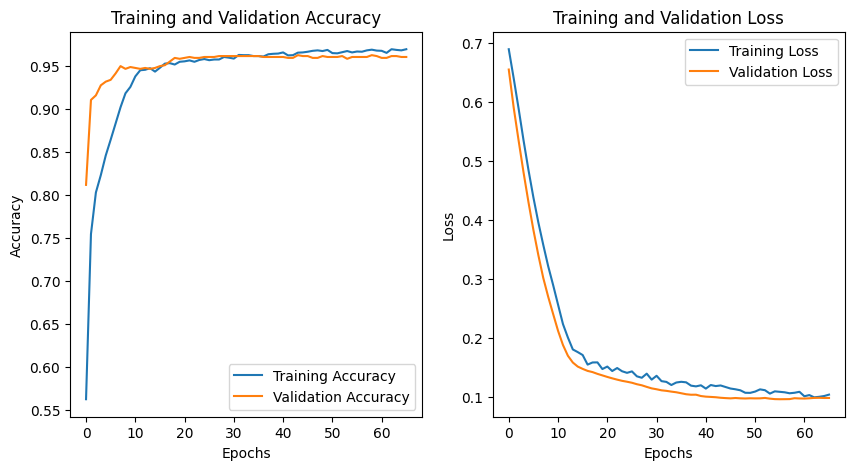

In [235]:
# Building model
model = Sequential()
model.add(Input(shape=(n_features,)))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(2, activation="relu"))
model.add(Dense(1, activation='sigmoid'))

# Compiling model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Initializing EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Training model with EarlyStopping callback
history = model.fit(X_train, y_train, epochs=500, batch_size=n_data//6, validation_split=0.2, verbose=1, callbacks=[early_stopping])

# Evaluating the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"\nTest Accuracy: {test_acc * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Plotting accuracy
fig = plt.figure(num=1, figsize=(10, 5))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Training and Validation Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plotting loss
ax1 = fig.add_subplot(1, 2, 2)
ax1.plot(history.history['loss'], label='Training Loss')
ax1.plot(history.history['val_loss'], label='Validation Loss')
ax1.set_title('Training and Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
plt.show()

In [237]:
# Predicting using the model
random_index = np.random.randint(0, X_test.shape[0])
random_row = X_test[random_index]
random_label = y_test[random_index][0]

prediction = model.predict(random_row.reshape(1, n_features), verbose=0)
predicted_class = np.round(prediction[0][0])

print(f"Predicted: {predicted_class}, Actual: {random_label}")

Predicted: 1.0, Actual: 1


### Conclusions

In this project, I cleaned and analysed the 'Users vs bots classification' dataset from Kaggle and then built a neural network model to classify bots from users. Here are the key points that can be concluded:
1. Most Bot accounts would not have a photo, whereas most Human accounts would.
2. Messages from Bots would have higher keywords on average than Humans.
3. Most accounts that have an interest are Humans.
4. Messages from Bots would have higher text length on average than Humans.
5. Accounts that are verified are mostly Humans.
6. To classify the accounts, I built an Artificial Neural Network model that gives around 97% accuracy.

#### Suggestions

Here are the suggestions that could be taken away from this Project:
1. Factors like having a photo, interests, messages with high average text length and keywords can be used to identify Bot accounts and can be used to decide whether to interact with these accounts or not.